In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import learning_curve
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy.stats import randint, uniform
import time

In [2]:
# Set random seed for reproducibility
np.random.seed(42)

# Load the California housing dataset
housing = fetch_california_housing()
X, y = housing.data, housing.target
feature_names = housing.feature_names

print(f"Dataset shape: {X.shape}")
print(f"Features: {feature_names}")

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Dataset shape: (20640, 8)
Features: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


In [3]:
# Function to evaluate and print model performance
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"\n{model_name} Performance:")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²: {r2:.4f}")
    
    return {'Model': model_name, 'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R²': r2}

In [4]:
# Define models and their parameter distributions for RandomizedSearchCV
models = {
    'Ridge': {
        'model': Ridge(),
        'params': {
            'ridge__alpha': uniform(0.01, 10)
        }
    },
    'Lasso': {
        'model': Lasso(),
        'params': {
            'lasso__alpha': uniform(0.01, 10),
            'lasso__max_iter': randint(1000, 3000)
        }
    },
    'ElasticNet': {
        'model': ElasticNet(),
        'params': {
            'elasticnet__alpha': uniform(0.01, 10),
            'elasticnet__l1_ratio': uniform(0.1, 0.9),
            'elasticnet__max_iter': randint(1000, 3000)
        }
    },
    'RandomForest': {
        'model': RandomForestRegressor(),
        'params': {
            'randomforest__n_estimators': randint(50, 200),
            'randomforest__max_depth': randint(5, 30),
            'randomforest__min_samples_split': randint(2, 20),
            'randomforest__min_samples_leaf': randint(1, 10)
        }
    },
    'GradientBoosting': {
        'model': GradientBoostingRegressor(),
        'params': {
            'gradientboosting__n_estimators': randint(50, 200),
            'gradientboosting__learning_rate': uniform(0.01, 0.3),
            'gradientboosting__max_depth': randint(3, 10),
            'gradientboosting__min_samples_split': randint(2, 20),
            'gradientboosting__subsample': uniform(0.6, 0.4)
        }
    },
    'SVR': {
        'model': SVR(),
        'params': {
            'svr__C': uniform(0.1, 10),
            'svr__epsilon': uniform(0.01, 0.5),
            'svr__gamma': ['scale', 'auto'] + list(uniform(0.001, 0.1).rvs(5))
        }
    }
}

In [5]:
# Number of iterations for RandomizedSearchCV
n_iter = 20
cv_folds = 5

# Store results for comparison
results = []
best_models = {}

In [6]:
# Run RandomizedSearchCV for each model
for model_name, model_info in models.items():
    print(f"\nRunning RandomizedSearchCV for {model_name}...")
    start_time = time.time()
    
    # Create a pipeline with scaling and the model
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        (model_name.lower(), model_info['model'])
    ])
    
    # Create and run the randomized search
    random_search = RandomizedSearchCV(
        pipeline,
        param_distributions=model_info['params'],
        n_iter=n_iter,
        cv=cv_folds,
        scoring='neg_mean_squared_error',
        verbose=1,
        random_state=42,
        n_jobs=-1
    )
    
    random_search.fit(X_train, y_train)
    
    elapsed_time = time.time() - start_time
    print(f"Time taken: {elapsed_time:.2f} seconds")
    
    # Store the best estimator
    best_models[model_name] = random_search.best_estimator_
    
    # Evaluate the model and store results
    results.append(evaluate_model(random_search.best_estimator_, X_test, y_test, model_name))
    
    # Print best parameters
    print(f"Best parameters: {random_search.best_params_}")
    print(f"Best score (neg_mean_squared_error): {random_search.best_score_:.4f}")


Running RandomizedSearchCV for Ridge...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Time taken: 4.37 seconds

Ridge Performance:
MSE: 0.5559
RMSE: 0.7456
MAE: 0.5332
R²: 0.5758
Best parameters: {'ridge__alpha': 0.21584494295802448}
Best score (neg_mean_squared_error): -0.5193

Running RandomizedSearchCV for Lasso...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Time taken: 0.41 seconds

Lasso Performance:
MSE: 0.5525
RMSE: 0.7433
MAE: 0.5417
R²: 0.5783
Best parameters: {'lasso__alpha': 0.017787658410143285, 'lasso__max_iter': 1955}
Best score (neg_mean_squared_error): -0.5359

Running RandomizedSearchCV for ElasticNet...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Time taken: 0.42 seconds

ElasticNet Performance:
MSE: 0.5818
RMSE: 0.7628
MAE: 0.5618
R²: 0.5560
Best parameters: {'elasticnet__alpha': 0.08066305219717405, 'elasticnet__l1_ratio': 0.12075618253727419, 'elasticnet__max_iter': 1474}
Best score (neg_mean_squared_error): -0.5

In [7]:
# Create a DataFrame with results for comparison
results_df = pd.DataFrame(results)
print("\nModel Comparison:")
results_df.sort_values('RMSE')


Model Comparison:


,Model,MSE,RMSE,MAE,R²
4,GradientBoosting,0.211105,0.459462,0.300587,0.838901
3,RandomForest,0.260971,0.510853,0.330672,0.800848
5,SVR,0.321710,0.567195,0.386442,0.754497
1,Lasso,0.552536,0.743327,0.541712,0.578349
0,Ridge,0.555884,0.745576,0.533199,0.575794
2,ElasticNet,0.581821,0.762772,0.561764,0.556001


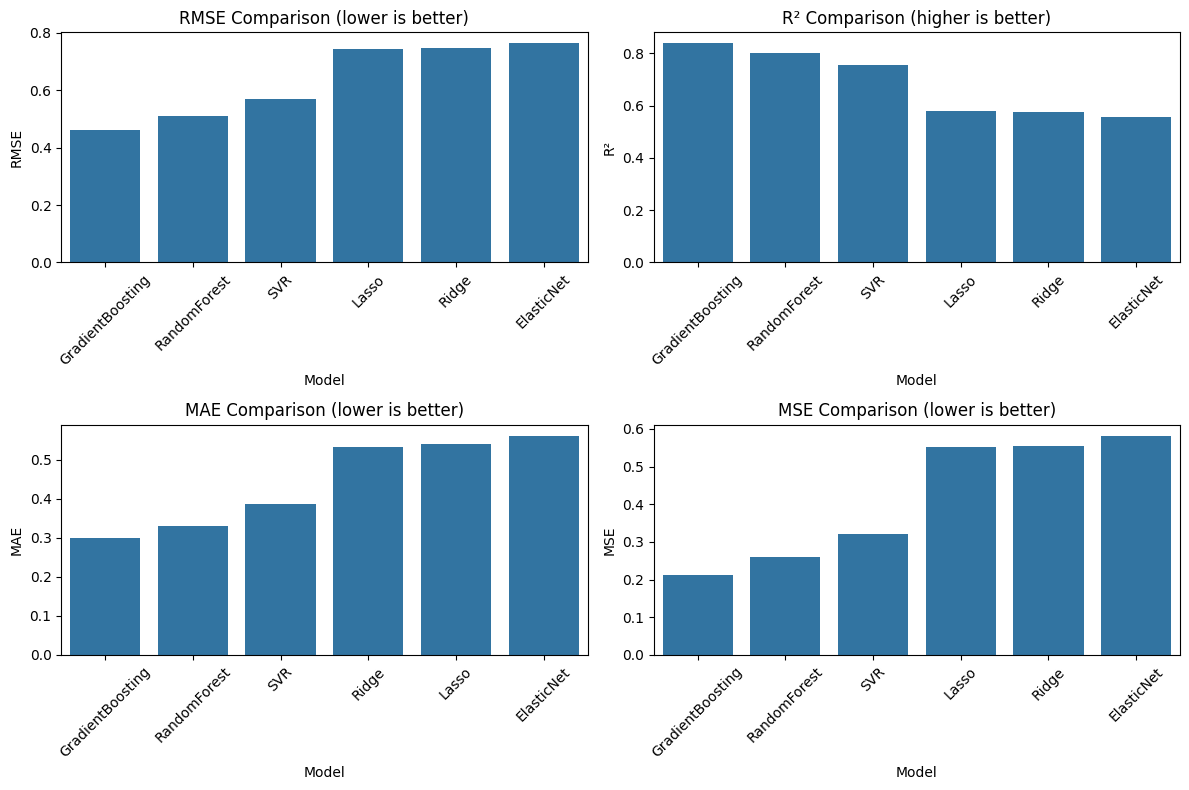

In [8]:
# Visualize model performance
plt.figure(figsize=(12, 8))

# RMSE comparison
plt.subplot(2, 2, 1)
sns.barplot(x='Model', y='RMSE', data=results_df.sort_values('RMSE'))
plt.title('RMSE Comparison (lower is better)')
plt.xticks(rotation=45)

# R² comparison
plt.subplot(2, 2, 2)
sns.barplot(x='Model', y='R²', data=results_df.sort_values('R²', ascending=False))
plt.title('R² Comparison (higher is better)')
plt.xticks(rotation=45)

# MAE comparison
plt.subplot(2, 2, 3)
sns.barplot(x='Model', y='MAE', data=results_df.sort_values('MAE'))
plt.title('MAE Comparison (lower is better)')
plt.xticks(rotation=45)

# MSE comparison
plt.subplot(2, 2, 4)
sns.barplot(x='Model', y='MSE', data=results_df.sort_values('MSE'))
plt.title('MSE Comparison (lower is better)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('model_comparison_1.png')
plt.show()

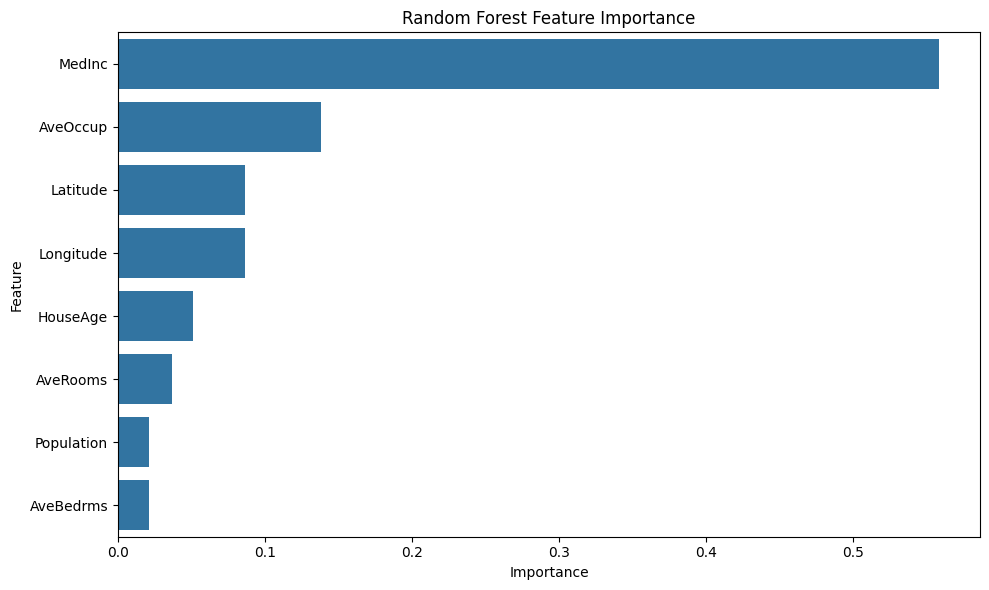


Random Forest Feature Importance:
      Feature  Importance
0      MedInc    0.558665
5    AveOccup    0.138083
6    Latitude    0.086560
7   Longitude    0.086262
1    HouseAge    0.051066
2    AveRooms    0.037111
4  Population    0.021370
3   AveBedrms    0.020883


In [9]:
# Feature importance for tree-based models
if 'RandomForest' in best_models:
    rf_model = best_models['RandomForest'].named_steps['randomforest']
    feature_importances = pd.DataFrame({
        'Feature': feature_names,
        'Importance': rf_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importances)
    plt.title('Random Forest Feature Importance')
    plt.tight_layout()
    plt.savefig('Feature_Importance')
    plt.show()
    
    print("\nRandom Forest Feature Importance:")
    print(feature_importances)


Generating learning curve for the best model: GradientBoosting


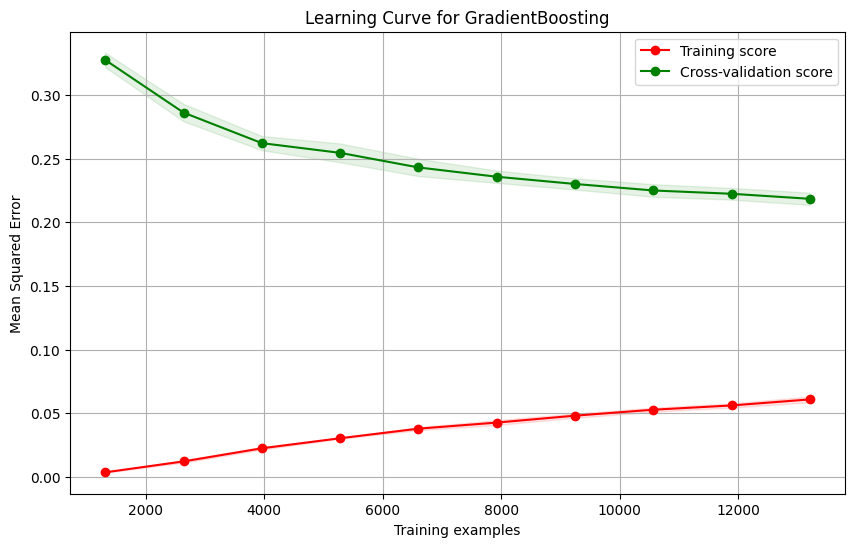

In [10]:
# Learning curves for the best model (based on RMSE)
best_model_name = results_df.sort_values('RMSE').iloc[0]['Model']
print(f"\nGenerating learning curve for the best model: {best_model_name}")

best_pipeline = best_models[best_model_name]

train_sizes, train_scores, test_scores = learning_curve(
    best_pipeline, X_train, y_train, 
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5, scoring='neg_mean_squared_error'
)

train_scores_mean = -np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.title(f"Learning Curve for {best_model_name}")
plt.xlabel("Training examples")
plt.ylabel("Mean Squared Error")
plt.grid()

plt.fill_between(train_sizes, 
                 train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, 
                 alpha=0.1, color="r")
plt.fill_between(train_sizes, 
                 test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, 
                 alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.legend(loc="best")
plt.savefig('Learning_Curve')
plt.show()

In [11]:
print("\nRandomizedSearchCV with different regression models completed successfully!")


RandomizedSearchCV with different regression models completed successfully!
